## ARC Frechet Model- Crypto OB Application

In [1]:
! pip install arch
! pip install empyrical

In [2]:
import arch
from arch import arch_model
from arch.univariate import GARCH
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import sys
import math
from matplotlib.dates import DateFormatter
from scipy.stats import invweibull
from arch.univariate import ARX # autoregressive model on max loss returns, 1 3, 12 lags
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from empyrical.stats import conditional_value_at_risk

sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

### Prep Data

In [3]:
# High Frequency Data
features_to_load = [
    "midprice_mean",
    "traded_price_mean"

]

# Last 2 weeks
end_date= datetime.datetime.strptime("2022-4-01","%Y-%m-%d")
start_date = datetime.datetime.strptime("2022-1-01","%Y-%m-%d")

# Choose buckketing
time_agg = "60sec" #60sec

high_freq= load_features(
    "ftx", "BTCUSDP", time_agg, start_date, end_date, features_to_load
)
high_freq.to_csv("data/1Min_BTCUSDP_Jan-APR.csv")

/opt/conda/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Query complete after 0.18s: 100%|██████████| 1/1 [00:00<00:00,  5.63query/s]
/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:444: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
Downloading: 100%|██████████| 452162/452162 [00:16<00:00, 26843.91rows/s]


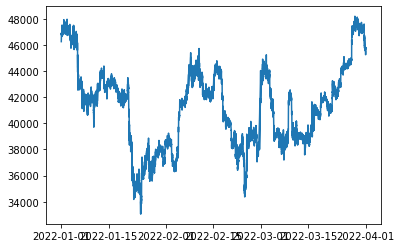

In [4]:
plt.plot(high_freq['midprice_mean'])

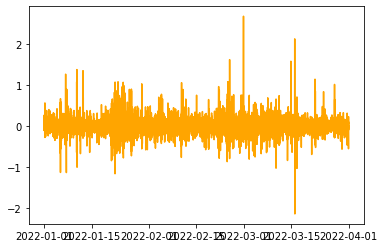

In [5]:
high_freq['return']=100 * high_freq['midprice_mean'].pct_change()
plt.plot(high_freq['return'].dropna(),color='orange')

In [6]:
high_freq=high_freq.dropna()
high_freq

,exchange,symbol,midprice_mean,traded_price_mean,return
timestamp,,,,,
2022-01-01 00:01:00+00:00,ftx,BTCUSDP,46260.562165,46279.262082,0.029794
2022-01-01 00:02:00+00:00,ftx,BTCUSDP,46351.538462,46349.094633,0.196661
2022-01-01 00:03:00+00:00,ftx,BTCUSDP,46344.689597,46363.427928,-0.014776
2022-01-01 00:04:00+00:00,ftx,BTCUSDP,46328.115406,46325.155718,-0.035763
2022-01-01 00:05:00+00:00,ftx,BTCUSDP,46369.754973,46385.551320,0.089880
...,...,...,...,...,...
2022-03-31 23:55:00+00:00,ftx,BTCUSDP,45509.673008,45508.789683,-0.082392
2022-03-31 23:56:00+00:00,ftx,BTCUSDP,45516.542577,45513.944030,0.015095
2022-03-31 23:57:00+00:00,ftx,BTCUSDP,45523.948691,45523.597222,0.016271


In [7]:
def generate_max(series): 
    '''
    Here is largest negative return for  60 minute buckets consisting of 1 min increments
    
    '''
    
    max_values=pd.Series([])
    for i in range(0,math.floor(len(series.values)/60)):  # hourly 
        max_elt=min(series[i*60:(i+1)*60])
        max_values=max_values.append(pd.Series([max_elt],index=[series.index[i*60]])) # index 
 
    return -max_values # view losses as positive

In [8]:
max_series=generate_max(high_freq['return'])

<ipython-input-7-8db77b170928>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  max_values=pd.Series([])


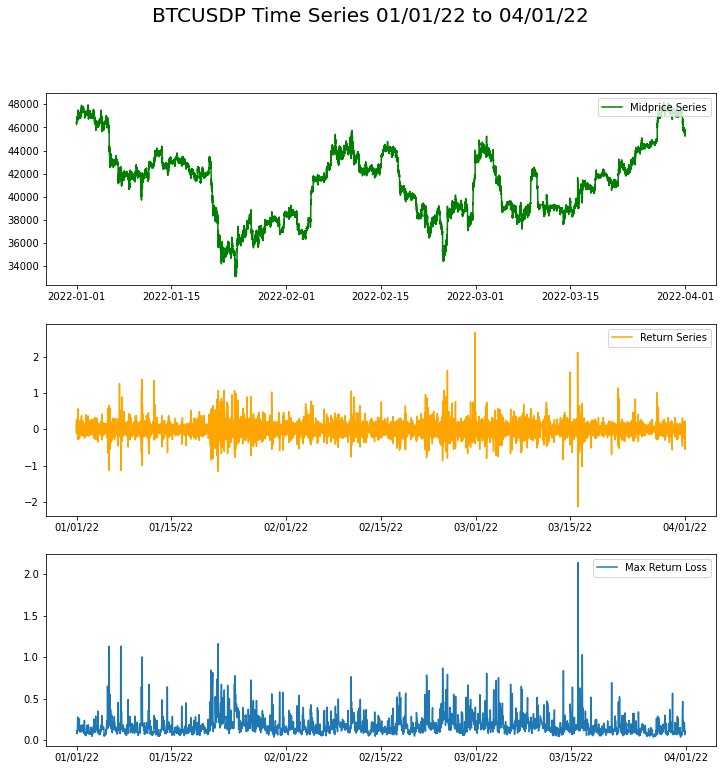

In [9]:

fig,ax = plt.subplots(3,1,figsize=(12,12))
fig.suptitle("BTCUSDP Time Series 01/01/22 to 04/01/22",fontsize=20)
ax[0].plot(high_freq['midprice_mean'],color='green',label='Midprice Series')
ax[0].legend(loc='upper right')
ax[2].plot(max_series, label='Max Return Loss')
ax[1].plot(high_freq['return'], label='Return Series',color='orange') # negative, sampled every 60 seconds
ax[1].legend()
ax[2].legend()
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))
ax[2].xaxis.set_major_formatter(DateFormatter("%D"))

## Fitting a Frechet / Inverse Weibull Dist 

### Break Train set into two period
- One to estimate Location parameter,
- Fix location param, allow time-varying shape and scale

In [10]:
global_shape,global_loc,global_scale=invweibull.fit(max_series[:1500])
1/global_shape,global_loc,global_scale

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(0.32846771251159396, -0.05850736465592662, 0.18469752767621367)

No handles with labels found to put in legend.


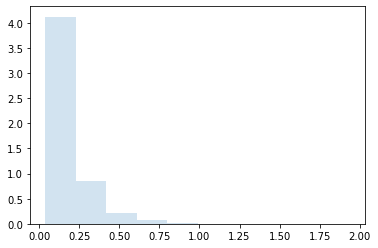

In [11]:
r = invweibull.rvs(global_shape,loc=global_loc,scale=global_scale, size=1000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

## Empirical Data

No handles with labels found to put in legend.


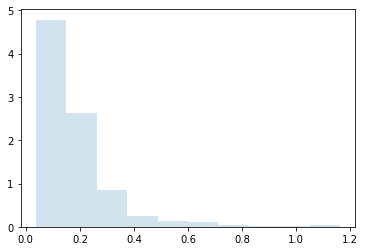

In [12]:
plt.hist(max_series[:750], density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

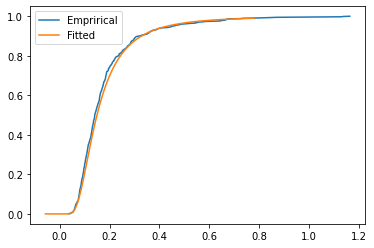

In [13]:
### Comparing Static distributions
ecdf=ECDF(max_series[:750])
plt.plot(ecdf.x,ecdf.y,label='Emprirical')

n=100
x = np.linspace(invweibull.ppf(0.01, 1/global_shape,loc=global_loc,scale=global_scale),
                invweibull.ppf(0.99, global_shape,loc=global_loc,scale=global_scale), n)
frechet_cdf=invweibull.cdf(x,global_shape,loc=global_loc,scale=global_scale)
plt.plot(x,frechet_cdf,label='Fitted')
plt.legend()


**Notes**
- Exhibited is empirical pdf and cdf against the fitted frechet distribution off global trained loc/scale/shape parameters
- This is a static approach, no time varying is incorporated

# Incorporating time varying parameters 

In [14]:
k= 750# num samples

time_vary=pd.DataFrame()
mod=np.mod(len(high_freq['return']),60)
time_vary['return']=pd.Series(np.median(np.array(high_freq['return'][:-mod]).reshape(-1, 60),axis=1),index=max_series.index)
time_vary['max_loss']=max_series


shape_vals=pd.Series([1/global_shape],index=[max_series.index[749]])
loc_vals=pd.Series([global_loc],index=[max_series.index[749]])
scale_vals=pd.Series([global_scale],index=[max_series.index[749]])
theoretical_max_loss=pd.Series()

i=0
for index,elt in max_series[750:1500].iteritems(): 
    
    shape,loc,scale=invweibull.fit(max_series[:750+i],floc=global_loc) # fit all data up until observ, fix location param 
    
    shape_vals=shape_vals.append(pd.Series([1/shape],index=[index]))
    loc_vals=loc_vals.append(pd.Series([loc],index=[index]))
    scale_vals=scale_vals.append(pd.Series([scale],index=[index]))
    theoretical_max_loss=theoretical_max_loss.append(pd.Series([]))
    i=i+1
        
time_vary['shape']=shape_vals
time_vary['loc']=loc_vals
time_vary['scale']=scale_vals
time_vary['shape']=time_vary['shape'].bfill()
time_vary['loc']=time_vary['loc'].bfill()
time_vary['scale']=time_vary['scale'].bfill()
time_vary.to_csv('data/time_varying_param.csv')

<ipython-input-14-cb204d0d7afb>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  theoretical_max_loss=pd.Series()
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
<ipython-input-14-cb204d0d7afb>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  theoretical_max_loss=theoretical_max_loss.append(pd.Series([]))


In [15]:
time_vary

,return,max_loss,shape,loc,scale
2022-01-01 00:01:00+00:00,0.003128,0.110072,0.328468,-0.058507,0.184698
2022-01-01 01:01:00+00:00,0.008667,0.078208,0.328468,-0.058507,0.184698
2022-01-01 02:01:00+00:00,0.000547,0.075053,0.328468,-0.058507,0.184698
2022-01-01 03:01:00+00:00,-0.000336,0.084642,0.328468,-0.058507,0.184698
2022-01-01 04:01:00+00:00,-0.002632,0.277232,0.328468,-0.058507,0.184698
...,...,...,...,...,...
2022-03-31 18:36:00+00:00,-0.005253,0.105119,NaN,NaN,NaN
2022-03-31 19:36:00+00:00,-0.003501,0.211285,NaN,NaN,NaN
2022-03-31 20:36:00+00:00,-0.000315,0.063633,NaN,NaN,NaN
2022-03-31 21:36:00+00:00,-0.002498,0.112248,NaN,NaN,NaN


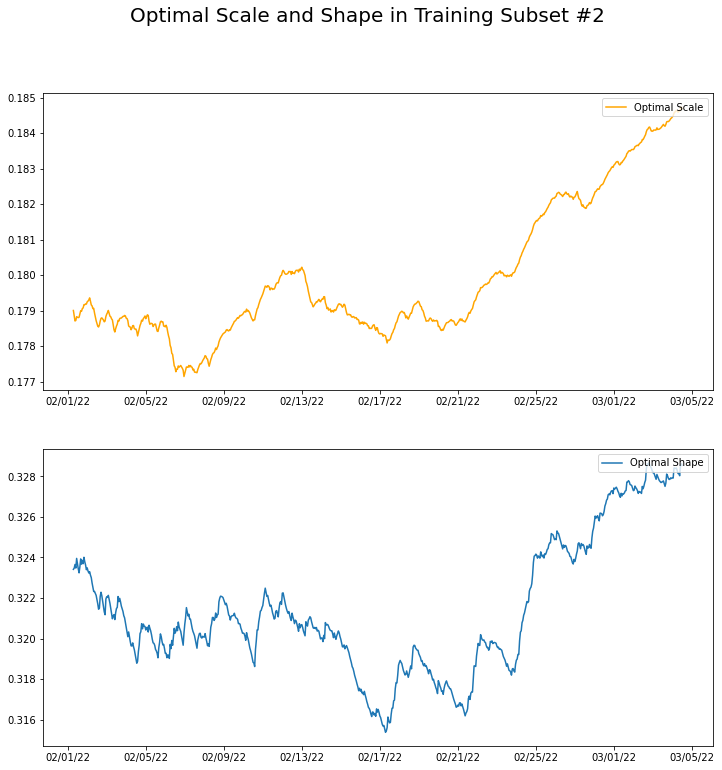

In [16]:

fig,ax = plt.subplots(2,1,figsize=(12,12))
fig.suptitle("Optimal Scale and Shape in Training Subset #2",fontsize=20)
ax[1].plot(time_vary['shape'][750:], label='Optimal Shape')
ax[0].plot(time_vary['scale'][750:], label='Optimal Scale',color='orange') # negative, sampled every 60 seconds
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))


### MLE Estimation of parameters

In [17]:
arc_model=pd.read_csv('data/time_varying_param.csv')
arc_model=arc_model.dropna() #ARC model only utilizes train set 
arc_model

,Unnamed: 0,return,max_loss,shape,loc,scale
0,2022-01-01 00:01:00+00:00,0.003128,0.110072,0.328468,-0.058507,0.184698
1,2022-01-01 01:01:00+00:00,0.008667,0.078208,0.328468,-0.058507,0.184698
2,2022-01-01 02:01:00+00:00,0.000547,0.075053,0.328468,-0.058507,0.184698
3,2022-01-01 03:01:00+00:00,-0.000336,0.084642,0.328468,-0.058507,0.184698
4,2022-01-01 04:01:00+00:00,-0.002632,0.277232,0.328468,-0.058507,0.184698
...,...,...,...,...,...,...
1495,2022-03-04 07:24:00+00:00,-0.000004,0.142836,0.328147,-0.058507,0.184619
1496,2022-03-04 08:24:00+00:00,-0.012881,0.753636,0.328034,-0.058507,0.184620
1497,2022-03-04 09:24:00+00:00,0.007937,0.252400,0.328554,-0.058507,0.184699
1498,2022-03-04 10:24:00+00:00,-0.001626,0.086328,0.328632,-0.058507,0.184738


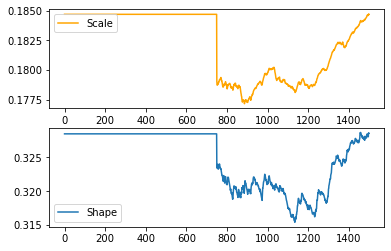

In [18]:
fig,ax = plt.subplots(2,1)


ax[1].plot(arc_model['shape'].values, label='Shape')
ax[0].plot(arc_model['scale'].values, label='Scale',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()


## Estimating coefficients from our train set

In [19]:
exog=-arc_model['max_loss'][749:-1].values 


In [20]:
mod = AutoReg(np.log(arc_model['shape'][750:].values),1,trend='c',exog=np.exp(exog))
res = mod.fit()
shape_params=res.params
print(res.summary())


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  750
Model:                   AutoReg-X(1)   Log Likelihood                4801.534
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 15 Apr 2022   AIC                            -15.648
Time:                        01:00:15   BIC                            -15.624
Sample:                             1   HQIC                           -15.639
                                  750                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0010      0.002     -0.603      0.546      -0.004       0.002
y.L1           0.9948      0.001    690.368      0.000       0.992       0.998
x1            -0.0058      0.000    -35.404      0.0

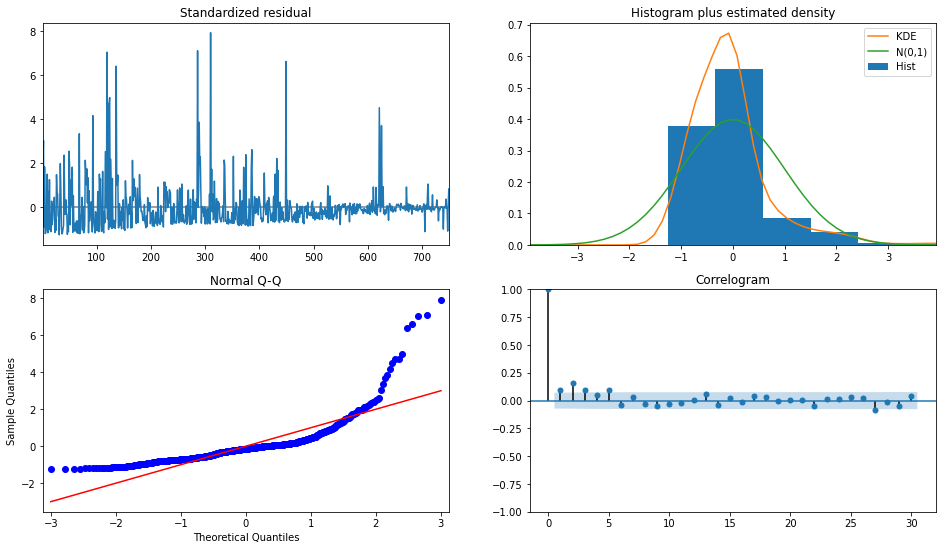

In [21]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

# Standardized residual shows non-explained by model -> should be normal
# Estimated density against N(0,1)
# Correlogram shows acf function 

In [22]:
mod = AutoReg(np.log(arc_model['scale'][750:].values),1,trend='c',exog=np.exp(exog))
res = mod.fit()
scale_params=res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  750
Model:                   AutoReg-X(1)   Log Likelihood                5439.001
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 15 Apr 2022   AIC                            -17.351
Time:                        01:00:16   BIC                            -17.326
Sample:                             1   HQIC                           -17.341
                                  750                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      1.678      0.093      -0.000       0.004
y.L1           0.9996      0.001   1683.519      0.000       0.998       1.001
x1            -0.0028   7.09e-05    -39.784      0.0

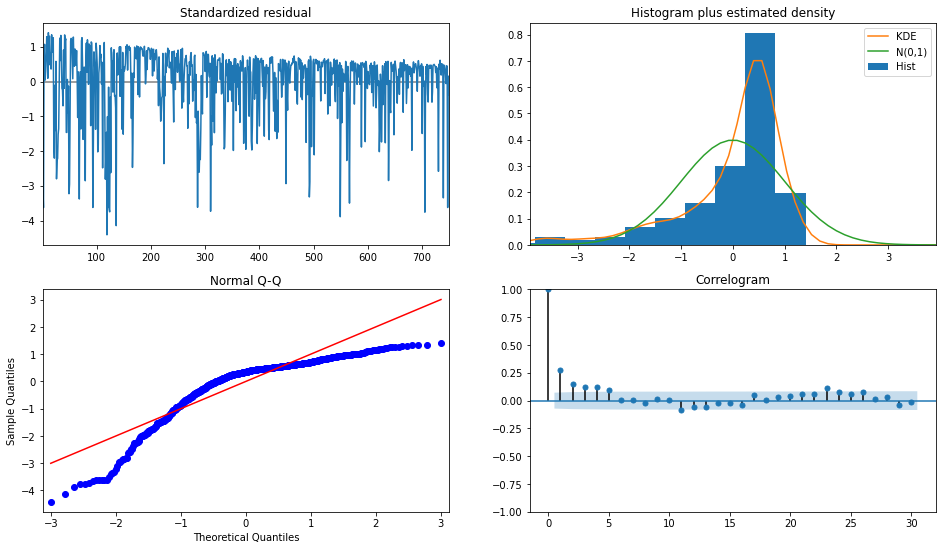

In [23]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

# Standardized residual shows non-explained by model
# Estimated density against N(0,1)
# Correlogram shows acf function 
# Errors are not normally distributed in the tails

### Retrain data in case of overwrite

In [24]:
k= 750# num samples

time_vary=pd.DataFrame()
time_vary['return']=-high_freq['return'][::60]
time_vary['max_loss']=max_series


shape_vals=pd.Series([1/global_shape],index=[max_series.index[749]])
loc_vals=pd.Series([global_loc],index=[max_series.index[749]])
scale_vals=pd.Series([global_scale],index=[max_series.index[749]])

i=0
for index,elt in max_series[750:1500].iteritems(): 
    
    shape,loc,scale=invweibull.fit(max_series[:750+i],floc=global_loc) # fit all data up until observ, fix location param 
    
    shape_vals=shape_vals.append(pd.Series([1/shape],index=[index]))
    loc_vals=loc_vals.append(pd.Series([loc],index=[index]))
    scale_vals=scale_vals.append(pd.Series([scale],index=[index]))
    i=i+1
        
time_vary['shape']=shape_vals
time_vary['loc']=loc_vals
time_vary['scale']=scale_vals
time_vary['shape']=time_vary['shape'].bfill()
time_vary['loc']=time_vary['loc'].bfill()
time_vary['scale']=time_vary['scale'].bfill()
time_vary.to_csv('data/time_vary.csv')

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


# Test Set
- Walk forward shape and scale parameters
- Need to retrain to retest based on for loop criteria

In [25]:
time_vary['loc']=time_vary['loc'].ffill() # fix loc
counter=0

cvar1=pd.Series([])
cvar2=pd.Series([])
cvar3=pd.Series([])

for x,row in time_vary.iterrows():
    if not np.isnan(row['shape']) and not np.isnan(row['scale']) :
        counter=counter+1
        cvar1=cvar1.append(pd.Series([np.nan],index=[x]))
        cvar2=cvar2.append(pd.Series([np.nan],index=[x]))
        cvar3=cvar3.append(pd.Series([np.nan],index=[x]))
        continue
    row['shape']=(np.exp(shape_params[0]+shape_params[1]*np.log(time_vary['shape'][counter-1])+shape_params[2]*np.exp(-time_vary['max_loss'][counter-1]) ))# walk forward from our eqns
    row['scale']=np.exp(scale_params[0]+scale_params[1]*np.log(time_vary['scale'][counter-1])+scale_params[2]*np.exp(-time_vary['max_loss'][counter-1]) )# walk forward 
    
    # empirical cvars for each fitted period outside of train set #1 
    cvar1=cvar1.append(pd.Series([conditional_value_at_risk(time_vary['max_loss'][:counter],0.9)],index=[x]))
    cvar2=cvar2.append(pd.Series([conditional_value_at_risk(time_vary['max_loss'][:counter],0.95)],index=[x]))
    cvar3=cvar3.append(pd.Series([conditional_value_at_risk(time_vary['max_loss'][:counter],0.99)],index=[x]))
    
    counter=counter+1
time_vary['cvar_0.90']=cvar1
time_vary['cvar_0.95']=cvar2
time_vary['cvar_0.99']=cvar3
    
time_vary

<ipython-input-25-11a3603cbd13>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar1=pd.Series([])
<ipython-input-25-11a3603cbd13>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar2=pd.Series([])
<ipython-input-25-11a3603cbd13>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar3=pd.Series([])


,return,max_loss,shape,loc,scale,cvar_0.90,cvar_0.95,cvar_0.99
timestamp,,,,,,,,
2022-01-01 00:01:00+00:00,-0.029794,0.110072,0.328468,-0.058507,0.184698,NaN,NaN,NaN
2022-01-01 01:01:00+00:00,0.040401,0.078208,0.328468,-0.058507,0.184698,NaN,NaN,NaN
2022-01-01 02:01:00+00:00,0.020991,0.075053,0.328468,-0.058507,0.184698,NaN,NaN,NaN
2022-01-01 03:01:00+00:00,-0.015539,0.084642,0.328468,-0.058507,0.184698,NaN,NaN,NaN
2022-01-01 04:01:00+00:00,-0.042882,0.277232,0.328468,-0.058507,0.184698,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-03-31 19:36:00+00:00,-0.060101,0.211285,0.308830,-0.058507,0.180744,0.147443,0.158731,0.173700
2022-03-31 20:36:00+00:00,-0.054490,0.063633,0.308938,-0.058507,0.180762,0.147476,0.158756,0.173717
2022-03-31 21:36:00+00:00,0.036963,0.112248,0.308812,-0.058507,0.180714,0.147432,0.158710,0.173666


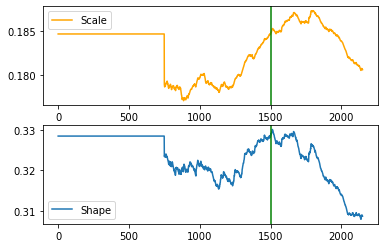

In [26]:
fig,ax = plt.subplots(2,1)


ax[1].plot(time_vary['shape'].values, label='Shape')
ax[0].plot(time_vary['scale'].values, label='Scale',color='orange') # flip returns to view
ax[0].axvline(1500,color='green')
ax[1].axvline(1500,color='green')
ax[0].legend()
ax[1].legend()

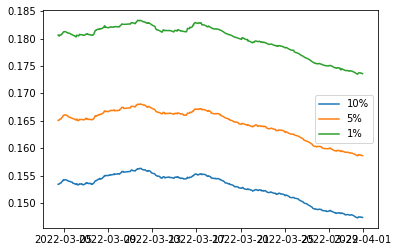

In [27]:
plt.plot(time_vary['cvar_0.90'],label='10%')
plt.plot(time_vary['cvar_0.95'],label='5%')
plt.plot(time_vary['cvar_0.99'],label='1%')
plt.legend()

# Test Series Comparisons

## Shape Param comparison to Tail index (CVAR)

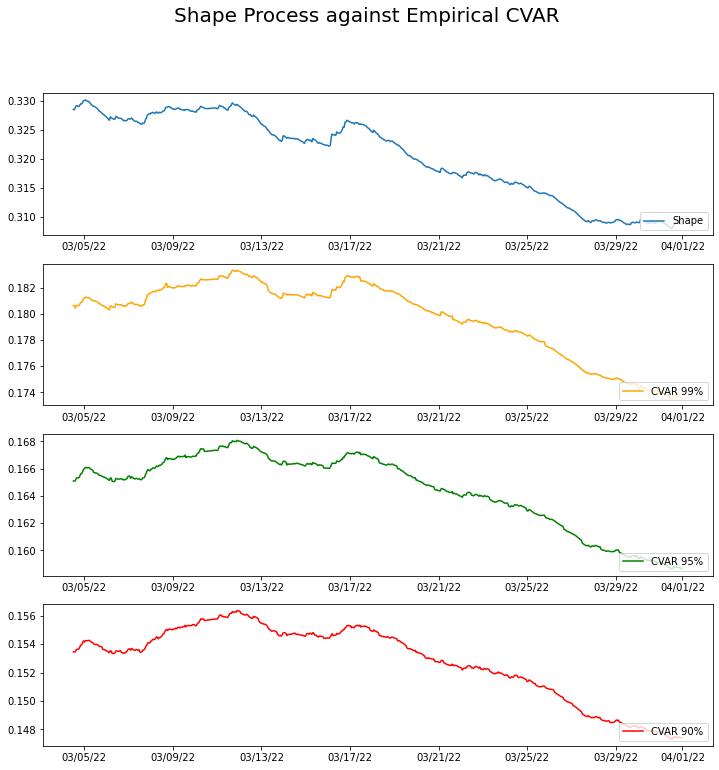

In [28]:
fig,ax = plt.subplots(4,1,figsize=(12,12))

fig.suptitle("Shape Process against Empirical CVAR",fontsize=20)

ax[0].plot(time_vary['shape'][1500:], label='Shape')
ax[1].plot(time_vary['cvar_0.99'][1500:], label='CVAR 99%',color='orange') 
ax[2].plot(time_vary['cvar_0.95'][1500:], label='CVAR 95%',color='green') 
ax[3].plot(time_vary['cvar_0.90'][1500:], label='CVAR 90%',color='red') 
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
ax[3].legend(loc='lower right')
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))
ax[2].xaxis.set_major_formatter(DateFormatter("%D"))
ax[3].xaxis.set_major_formatter(DateFormatter("%D"))

In [29]:
print(np.corrcoef(time_vary['shape'][1500:],time_vary['cvar_0.90'][1500:]))
print(np.corrcoef(time_vary['shape'][1500:],time_vary['cvar_0.95'][1500:]))
print(np.corrcoef(time_vary['shape'][1500:],time_vary['cvar_0.99'][1500:]))

[[1.         0.94133238]
 [0.94133238 1.        ]]
[[1.         0.94072169]
 [0.94072169 1.        ]]
[[1.         0.93766537]
 [0.93766537 1.        ]]


## Scale Parameter comparison to GARCH on Midprice Series 

- Compute GARCH on entire time varying parameters, compute correlation on test set

In [30]:
loss_returns=high_freq[::60]
loss_returns

,exchange,symbol,midprice_mean,traded_price_mean,return
timestamp,,,,,
2022-01-01 00:01:00+00:00,ftx,BTCUSDP,46260.562165,46279.262082,0.029794
2022-01-01 01:01:00+00:00,ftx,BTCUSDP,46641.572460,46638.333333,-0.040401
2022-01-01 02:01:00+00:00,ftx,BTCUSDP,46801.487682,46797.940171,-0.020991
2022-01-01 03:01:00+00:00,ftx,BTCUSDP,46825.768601,46823.741379,0.015539
2022-01-01 04:01:00+00:00,ftx,BTCUSDP,46852.164634,46851.676471,0.042882
...,...,...,...,...,...
2022-03-31 19:36:00+00:00,ftx,BTCUSDP,45770.647927,45773.537500,0.060101
2022-03-31 20:36:00+00:00,ftx,BTCUSDP,45693.698494,45698.242105,0.054490
2022-03-31 21:36:00+00:00,ftx,BTCUSDP,45812.373427,45812.517241,-0.036963


In [31]:
am = arch_model(loss_returns['return'][750:],rescale=True)  # generate 
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12134.994958182644
Iteration:      2,   Func. Count:     15,   Neg. LLF: 974868.988290365
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1582.2572174565348
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1462.3117306698086
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1439.1348171903524
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1439.1310865639316
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1439.1305946185548
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1439.1305057388092
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1439.1305049692724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1439.1305049692724
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:        

NameError: name 'cutoff' is not defined

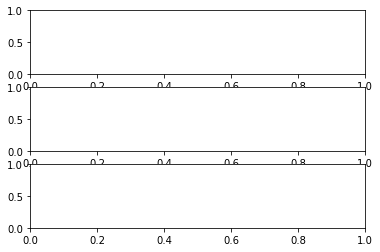

In [32]:
fig,ax = plt.subplots(3,1)



ax[0].plot(time_vary[time_vary.index>cutoff]['max_loss'], label='Scale Param',color='orange') # flip returns to view
ax[1].plot(pd.Series(res.conditional_volatility).rolling(250).mean(), label='Conditional Vol')

ax[2].plot(time_vary['scale'][750:],color='green',label="Shape")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [ ]:
np.corrcoef(pd.Series(res.conditional_volatility).rolling(250).mean()[750:],time_vary['scale'][1500:])